# Introduction

This exercise is to build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In this model building exercise we will use the images dataset provided by "Skin cancer ISIC The International Skin Imaging Collaboration"

There are datasets, for training and test and each of them contain 9 classes of images depicting various skin problems.

## Libraries Import

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

2024-01-10 19:03:46.127308: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-10 19:03:46.156433: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-10 19:03:46.294320: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-10 19:03:46.294403: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-10 19:03:46.314869: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

# Data Exploration

As described above the dataset has been given in the zip file so following OS Commands will unzip and place the images in the curren directory.

In [3]:
!rm -rf "Skin cancer ISIC The International Skin Imaging Collaboration"
!unzip -q CNN_assignment.zip 
!echo "Total Images found : `find './Skin cancer ISIC The International Skin Imaging Collaboration' -type f -name "*.jpg" |wc -l`"
!echo ""
!echo "Training dataset stats"
!echo ""
!IFS=$'\n';for d in `ls './Skin cancer ISIC The International Skin Imaging Collaboration'/Train`; do echo "${d} : `ls "./Skin cancer ISIC The International Skin Imaging Collaboration/Train/${d}" | wc -l`"; done

Total Images found : 2357

Training dataset stats

actinic keratosis : 114
basal cell carcinoma : 376
dermatofibroma : 95
melanoma : 438
nevus : 357
pigmented benign keratosis : 462
seborrheic keratosis : 77
squamous cell carcinoma : 181
vascular lesion : 139


### Train Dataset First Glance
It looks like there is a **class imbalance** as the training dataset has the diffrent no. of images for the different classes. This could become a potential problem in model building.

We will have to address it in due course of time

In [4]:
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Test')

image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(f"Train Dataset images : {image_count_train}")
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(f"Test Dataset images : {image_count_test}")

Train Dataset images : 2239
Test Dataset images : 118


## Load using keras.preprocessing

Loading these images using image_dataset_from_directory utility and at the same time resize the images to 128x128 resolution. We will use ```validation_split``` to split the train dataset in to train and validation data set with 80/20% proportion. 

In [5]:
(train_ds,val_ds)=tf.keras.utils.image_dataset_from_directory(data_dir_train,seed=120,image_size=(128,128),validation_split=0.2,subset="both")

test_ds=tf.keras.utils.image_dataset_from_directory(data_dir_test,image_size=(128,128))


Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Using 447 files for validation.
Found 118 files belonging to 9 classes.


As the output suggests there are 9 classes identified due to the 9 subdirectories inside Train and Test sub directories. Following are the class names,

In [6]:
class_names = train_ds.class_names
print("Class Names\n")
for cn in class_names:
    print(f"* {cn}")

Class Names

* actinic keratosis
* basal cell carcinoma
* dermatofibroma
* melanoma
* nevus
* pigmented benign keratosis
* seborrheic keratosis
* squamous cell carcinoma
* vascular lesion


## Keras Dataset
In this section we will see the structure of one of the keras dataset (train_ds) loaded to understand how it stores the data internally.

In [7]:
train_ds_rec = list(train_ds.take(1))
print(train_ds_rec[0][0].shape)
print(train_ds_rec[0][1].shape)

for images, labels in train_ds_rec:
  print(f"Image Dimensions and Channels : {images[0].shape}")
  print(len(images))
  print(len(labels))
  print(f"Class Id : {labels[0]}")

print(f"Total Batches : {len(train_ds)}")

(32, 128, 128, 3)
(32,)
Image Dimensions and Channels : (128, 128, 3)
32
32
Class Id : 7
Total Batches : 56


Keras loads the images in _PrefetchDataset which is a kind of lazy DataSet which would load the data from the store (disk) on demand basis. However as the name suggests it would pre-fetch a few items in advance to support the performance [PrefetchDataset](https://www.tensorflow.org/api_docs/python/tf/raw_ops/PrefetchDataset).

Each record in the dataset is a tuple of input data (X dataset) and the corresponding class (y variable). The X dataset is a tensor of 4 dimensions ```(32, 180, 180, 3)``` which represents the batch of 32 images each image of 128x128 dimensions and 3 channels of colour (RGB).

The y dataset is a single dimension of 32 elements each contain the tensor representing the respective class's encoded value. Each class string label is encoded as number by Keras library.

The total train batches are 56, hence 56 x 32 = 1792 images used for training.

## Visualize the data

Lets visualize the images data against their respective class. We will take only one sample from each class of training dataset.

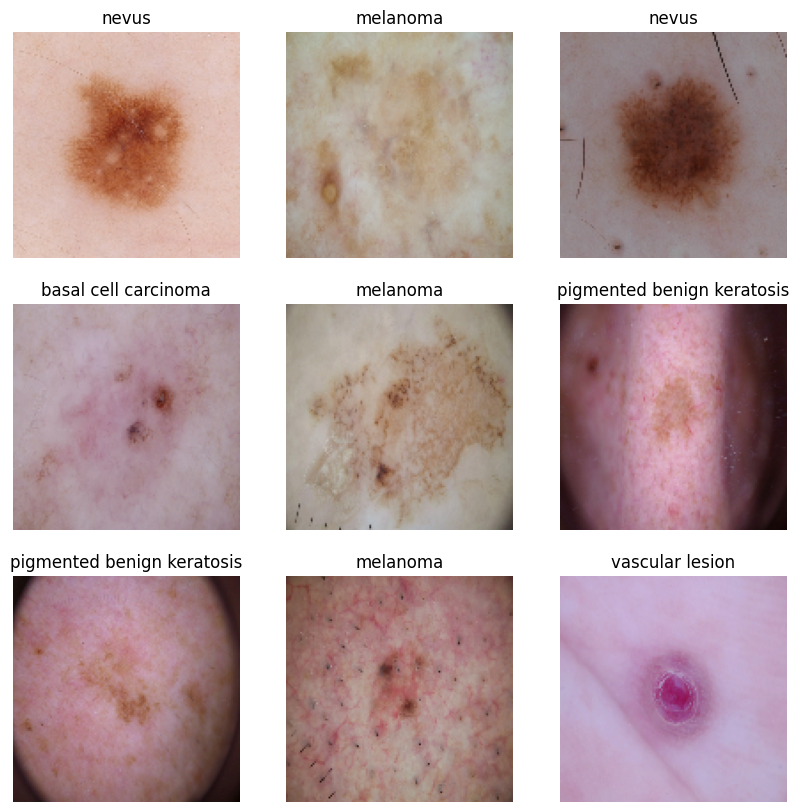

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):    
    ax = plt.subplot(3, 3, i + 1)    
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


# Building CNN Model

## Setting up Datasets

As explaiend earlier, Keras returned the PrefetchDatasets and now we will configure the training dataset how to prefetch and cache the input images.

The prefetching would speed up the processing especially when CPU and GPUs are used together. Currently on this machine, we don't have GPU.

AUTOTUNE will instruct Keras to automatically identify the no. of input records to prefetch.

In addition to prefetch+cache, we also have configured the shuffle of training dataset before it is fed to CNN model. This shuffle will ensure that CNN model does not get overfit due to sequencing of the input dataset.

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
# defining parameters
batch_size = 32
img_height = 128
img_width = 128

## CNN Model - 1

We will build the sequential model using Keras capable to categorize the input into one of the 9 classes. 

The first layer of model would be ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1) from (0,255).

This model has following layers,

1. Rescaling
2. Convolutional layer with 16 filters
3. Max Pooling
4. Convolutional layer with 32 filters
5. Max Pooling
6. Convolutional layer with 64 filters
7. Max Pooling
8. Flattening
9. Fully connected dense layer of 128 neurons
10. Dense output layer of 9 neurors (for 9 classes)

In [11]:

num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  #2D convolution layer (e.g. spatial convolution over images).
  layers.Conv2D(16, 3, padding='same', activation='relu'),

  
    layers.MaxPooling2D(),

  
  layers.Conv2D(32, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),

  
  layers.MaxPooling2D(),

  #Flattening - Convert into 1D feature vector.  Flattens all its structure to create a single long feature vector
  ##Flattens the input. Does not affect the batch size.
  layers.Flatten(),

  #fully connected layer
  #A hidden layer in which each node is connected to every node in the subsequent hidden layer.
  #A fully connected layer is also known as a dense layer.

  layers.Dense(128, activation='relu'),

  #Output layer
  layers.Dense(num_classes)
  
])



### Compile the model

Since this exercise of logistics regression (catagoization), we will use ```SparseCategoricalCrossentropy``` as loss function. Please note that we are **not** using ```CategoricalCrossentropy``` because our output layer generates the value between 1 to 9 instead of one-hot encoding like [0,0,0,1,0,0...]

The north-start metrics is accuracy and we use adam as optimizer.

In [12]:

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        1

### Train the model

As asked in the exercise we will train the model using 20 epochs, using training and validation dataset.

In [13]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 4s 39ms/step - loss: 1.9954 - accuracy: 0.2517 - val_loss: 1.7401 - val_accuracy: 0.3602
Epoch 2/20
56/56 [==============================] - 2s 34ms/step - loss: 1.7252 - accuracy: 0.3677 - val_loss: 1.5455 - val_accuracy: 0.5011
Epoch 3/20
56/56 [==============================] - 2s 34ms/step - loss: 1.4367 - accuracy: 0.4978 - val_loss: 1.4452 - val_accuracy: 0.4944
Epoch 4/20
56/56 [==============================] - 2s 34ms/step - loss: 1.3198 - accuracy: 0.5458 - val_loss: 1.4202 - val_accuracy: 0.5280
Epoch 5/20
56/56 [==============================] - 2s 34ms/step - loss: 1.2350 - accuracy: 0.5592 - val_loss: 1.3028 - val_accuracy: 0.5526
Epoch 6/20
56/56 [==============================] - 2s 34ms/step - loss: 1.1818 - accuracy: 0.5826 - val_loss: 1.2699 - val_accuracy: 0.5794
Epoch 7/20
56/56 [==============================] - 2s 35ms/step - loss: 1.0995 - accuracy: 0.6099 - val_loss: 1.4234 - val_accuracy: 0.5078
Epoch 8/20
56

### Visualizing training results

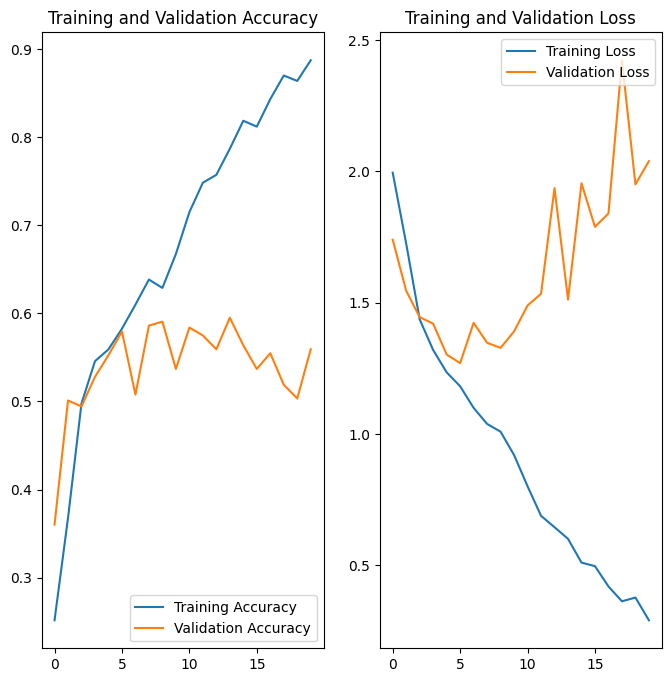

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Performance on test dataset

In [15]:
test_eval_result = model.evaluate(test_ds)
dict(zip(model.metrics_names, test_eval_result))

4/4 [==============================] - 1s 10ms/step - loss: 4.5187 - accuracy: 0.3898


{'loss': 4.518692970275879, 'accuracy': 0.38983049988746643}

### Model Performance Summary

1. As shown in the visualzation of results, the model is clearly underfit, and although the training dataset's accurracy approaching 0.8, the validation dataset accuracy remains below 0.6
2. Although after every epoch run the training loss is going down, the validation loss is fluctuating and not coming down. The loss describes how far the probabilities are predicted from the desired outcome probability. Having higher loss is an indicator of model is not trained enough.
3. The accuracy on test data is pretty low and the loss is quite high.

This model is not fit for predictions and we will have to build the better models.

## CNN Model - 2 (with Dropout)

Although Model - 1 is not overfit we will continue the same structure of model but with dropout layers in Convolutional and FC layers.

We just want to ensure that Dropouts don't worsen the performance.

In [16]:
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  layers.Conv2D(16, 3, padding='same', activation='relu'),

  layers.Dropout(0.2),

  layers.MaxPooling2D(),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.Dropout(0.2),
    
  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  
  layers.Dropout(0.2),

  layers.MaxPooling2D(),

  layers.Flatten(),

  layers.Dense(128, activation='relu'),

  layers.Dropout(0.2),

  layers.Dense(num_classes)
  
])

### Compile the model

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 dropout (Dropout)           (None, 128, 128, 16)      0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 64, 64, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 dropout_1 (Dropout)         (None, 64, 64, 32)        0         
                                                      

### Training the model

In [18]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 3s 50ms/step - loss: 2.0355 - accuracy: 0.2310 - val_loss: 1.9150 - val_accuracy: 0.3937
Epoch 2/20
56/56 [==============================] - 3s 48ms/step - loss: 1.7918 - accuracy: 0.3566 - val_loss: 1.7164 - val_accuracy: 0.4251
Epoch 3/20
56/56 [==============================] - 3s 48ms/step - loss: 1.5876 - accuracy: 0.4448 - val_loss: 1.5449 - val_accuracy: 0.4832
Epoch 4/20
56/56 [==============================] - 3s 47ms/step - loss: 1.4918 - accuracy: 0.4676 - val_loss: 1.6244 - val_accuracy: 0.4720
Epoch 5/20
56/56 [==============================] - 3s 49ms/step - loss: 1.3884 - accuracy: 0.5212 - val_loss: 1.4981 - val_accuracy: 0.4832
Epoch 6/20
56/56 [==============================] - 3s 50ms/step - loss: 1.3637 - accuracy: 0.5167 - val_loss: 1.4827 - val_accuracy: 0.4787
Epoch 7/20
56/56 [==============================] - 3s 50ms/step - loss: 1.2869 - accuracy: 0.5536 - val_loss: 1.4592 - val_accuracy: 0.4519
Epoch 8/20
56

### Visualizing training results

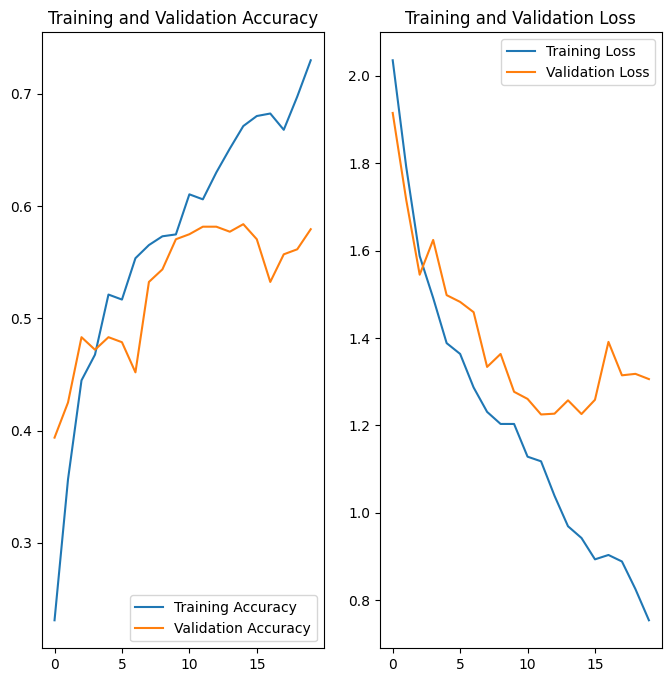

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Performance on test dataset

In [20]:
test_eval_result = model.evaluate(test_ds)
dict(zip(model.metrics_names, test_eval_result))

4/4 [==============================] - 1s 7ms/step - loss: 3.1181 - accuracy: 0.3305


{'loss': 3.118117570877075, 'accuracy': 0.3305084705352783}

### Model Performance Summary

1. The model is still underfitting although there is no adverse impact of Dropout on train and validation accuracy statistics.
2. The model is performing slightly better on unseen test data and that could be due the dropouts.

## CNN Model - 3 (More Conv layers)

In order to improve the accuracy, lets add one more convolutional layer and increase the number of filters in each convolutional layer compared to the previous models.

The increase of filters should help to capture more features and hence result into specific abstract features and in turn better input to FC Layer.

We are going to increase the FC Dense layer to 512 neurons to see if it improves the accuracy.

### Compile the model

In [21]:

num_classes = 9


model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),


  layers.Conv2D(32, 3, padding='same', activation='relu'),

  layers.Dropout(0.2),

  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Dropout(0.2),
    
  layers.MaxPooling2D(),

  layers.Conv2D(96, 3, padding='same', activation='relu'),
  
  layers.Dropout(0.2),

  layers.MaxPooling2D(),

  layers.Conv2D(128, 3, padding='same', activation='relu'),
  
  layers.Dropout(0.2),

  layers.MaxPooling2D(),    

  layers.Flatten(),

  layers.Dense(256, activation='relu'),

  layers.Dropout(0.2),

  layers.Dense(256, activation='relu'),

  layers.Dropout(0.2),    
    
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 dropout_4 (Dropout)         (None, 128, 128, 32)      0         
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 dropout_5 (Dropout)         (None, 64, 64, 64)        0         
                                                      

### Train the model

We will train with epoch = 20

In [22]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 7s 114ms/step - loss: 2.0389 - accuracy: 0.1987 - val_loss: 1.9350 - val_accuracy: 0.3132
Epoch 2/20
56/56 [==============================] - 5s 92ms/step - loss: 1.8822 - accuracy: 0.3214 - val_loss: 1.7413 - val_accuracy: 0.4094
Epoch 3/20
56/56 [==============================] - 5s 80ms/step - loss: 1.7756 - accuracy: 0.3594 - val_loss: 1.6089 - val_accuracy: 0.4183
Epoch 4/20
56/56 [==============================] - 4s 79ms/step - loss: 1.6519 - accuracy: 0.3917 - val_loss: 1.5753 - val_accuracy: 0.4072
Epoch 5/20
56/56 [==============================] - 5s 85ms/step - loss: 1.5795 - accuracy: 0.4414 - val_loss: 1.5110 - val_accuracy: 0.4922
Epoch 6/20
56/56 [==============================] - 5s 92ms/step - loss: 1.4846 - accuracy: 0.4900 - val_loss: 1.5142 - val_accuracy: 0.5011
Epoch 7/20
56/56 [==============================] - 5s 93ms/step - loss: 1.4149 - accuracy: 0.5078 - val_loss: 1.4514 - val_accuracy: 0.4944
Epoch 8/20
5

### Visualizing training results

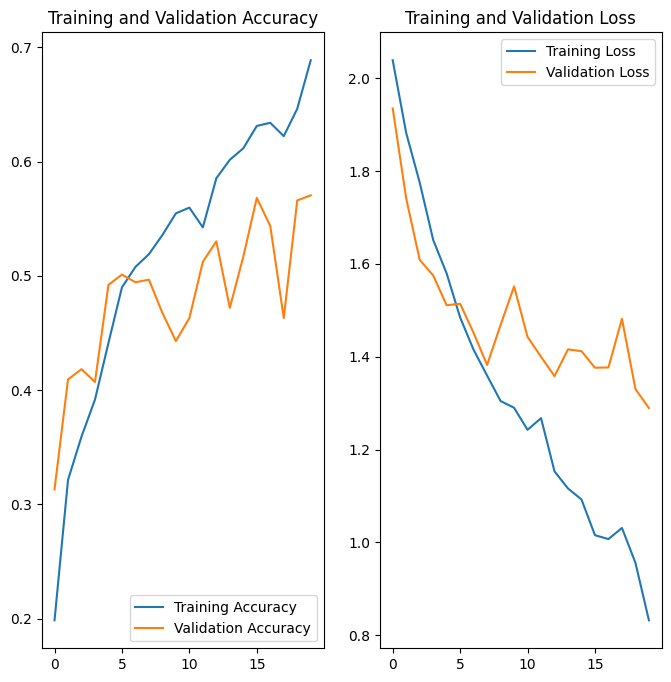

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Performance on test dataset

In [24]:
test_eval_result = model.evaluate(test_ds)
dict(zip(model.metrics_names, test_eval_result))

4/4 [==============================] - 1s 19ms/step - loss: 1.9454 - accuracy: 0.3644


{'loss': 1.945392370223999, 'accuracy': 0.3644067943096161}

### Model Performance Summary

The increase of convolutional layers and neurons in the dense FC layer did not make any difference the performance is pretty much same. This could be due to the class imbalance in input data and in next sections we will try to perform analysis on the input dataset.

# Class Imbalance

As mentioned in earlier section, there is a class imbalance in the training dataset. The imbalance is due to varying no. of images provided for each class and for some of the classes, the no. of images are much lesser than others.

In this section we will analyze that in details and discuss the strategies to fill the gap.


Class Statistics
-----------------------

Class=actinic keratosis, n=114 toaugment=348 (5.092%)
Class=vascular lesion, n=139 toaugment=323 (6.208%)
Class=seborrheic keratosis, n=77 toaugment=385 (3.439%)
Class=nevus, n=357 toaugment=105 (15.945%)
Class=melanoma, n=438 toaugment=24 (19.562%)
Class=basal cell carcinoma, n=376 toaugment=86 (16.793%)
Class=squamous cell carcinoma, n=181 toaugment=281 (8.084%)
Class=dermatofibroma, n=95 toaugment=367 (4.243%)
Class=pigmented benign keratosis, n=462 toaugment=0 (20.634%)

Distribution of class samples
-------------------------------



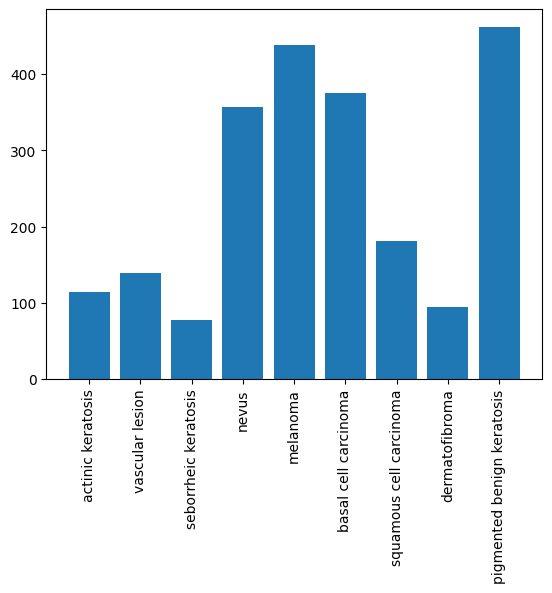


Samples deficiency
-------------------------------



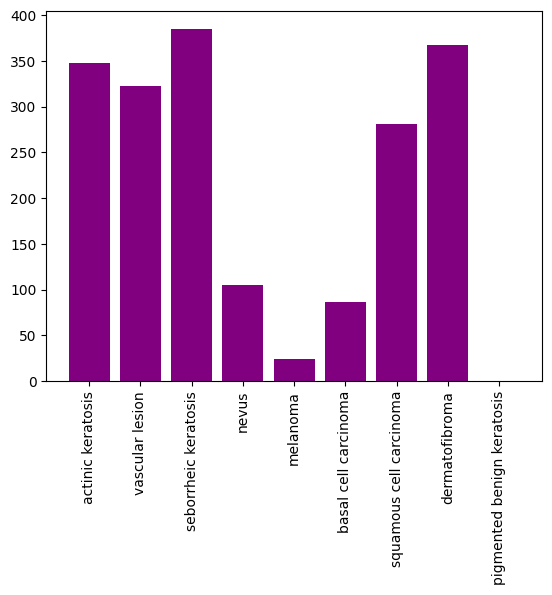

In [25]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

from sklearn.preprocessing import LabelEncoder
from collections import Counter

# split into input and output elements
X, y = original_df['Path'], original_df['Label']
# label encode the target variable
le = LabelEncoder()
y = le.fit_transform(y)
# summarize distribution
le_name_mapping = dict(zip(le.transform(le.classes_), le.classes_))

counter = Counter(y)

maxval = max(counter.values())

samples_to_augment = dict()
samples=dict()

print('\nClass Statistics')
print('-----------------------\n')
for k,v in counter.items():
    per = v / len(y) * 100    
    print('Class=%s, n=%d toaugment=%d (%.3f%%)' % (le_name_mapping[k], v, maxval-v, per))
    samples_to_augment[le_name_mapping[k]] = maxval-v
    samples[le_name_mapping[k]] = v
    
print('\nDistribution of class samples')
print('-------------------------------\n')
# plot the distribution
plt.bar(samples.keys(), samples.values())
plt.xticks(ticks=range(len(samples.keys())), labels=samples.keys(), rotation=90)
plt.show()

print('\nSamples deficiency')
print('-------------------------------\n')
plt.bar(samples_to_augment.keys(), samples_to_augment.values(),color='purple')
plt.xticks(ticks=range(len(samples_to_augment.keys())), labels=samples_to_augment.keys(), rotation=90)
plt.show()


## Summary

As shown in the above plots, we have a few categories having very less no. of images compared to others. For example, **seborrheic keratosis** has only 77 images compared to **pigmented benign keratosis** has 462 that's roughly 6 times difference.

We need to fill this gap and hence we will use two augmentation techniques. 

1. Using Keras to introduce augmentation transforms. It does not generate new images but introduces the image transformations while training the mode. This could result into activation of different features and possibly better fitting of CNN.
   
3. Using Augmentor library to pre generate the images in the directories and then perform the model training.
   

# Data Augmentation

In this section first perform manipulating / transforming existing images. The transformations would be of rotations, flipping, zooming, cropping, and translations. In later section we will use Augmentor library to generate new images.


## Data Augmentation using Keras

This section is to introduce augmentation transform to training dataset to increase diversity and hence better training of model.

In [26]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomTranslation(1,.5,fill_mode="reflect",interpolation="bilinear",seed=None,fill_value=0.0),
    layers.experimental.preprocessing.RandomCrop(img_height,img_width),
  ]
)

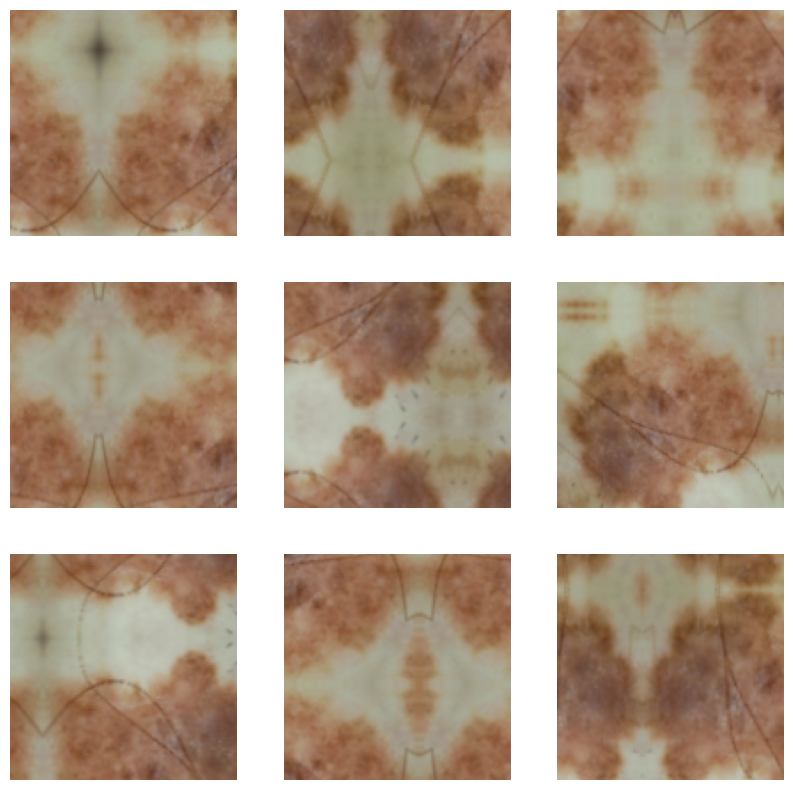

In [27]:

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### CNN Model - 4 (Transformation Augmentation)

#### Compile the model

In [28]:

num_classes = 9


model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.Dropout(0.2),
  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Dropout(0.2),
  layers.MaxPooling2D(),

  layers.Conv2D(96, 3, padding='same', activation='relu'),
  layers.Dropout(0.2),  
  layers.MaxPooling2D(),

  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.Dropout(0.2),  
  layers.MaxPooling2D(),    

  layers.Flatten(),

  layers.Dense(256, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(num_classes)
  
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 dropout_10 (Dropout)        (None, 128, 128, 32)      0         
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 64, 64, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 64, 64, 64)        18496     
                                                      

#### Training the model

In [29]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 6s 103ms/step - loss: 2.0267 - accuracy: 0.2372 - val_loss: 1.9614 - val_accuracy: 0.3333
Epoch 2/20
56/56 [==============================] - 6s 102ms/step - loss: 1.8121 - accuracy: 0.3220 - val_loss: 1.7542 - val_accuracy: 0.3624
Epoch 3/20
56/56 [==============================] - 6s 101ms/step - loss: 1.7156 - accuracy: 0.3722 - val_loss: 1.7315 - val_accuracy: 0.3714
Epoch 4/20
56/56 [==============================] - 6s 99ms/step - loss: 1.6749 - accuracy: 0.3772 - val_loss: 1.6384 - val_accuracy: 0.4519
Epoch 5/20
56/56 [==============================] - 6s 98ms/step - loss: 1.6185 - accuracy: 0.4090 - val_loss: 1.6667 - val_accuracy: 0.3982
Epoch 6/20
56/56 [==============================] - 5s 98ms/step - loss: 1.6160 - accuracy: 0.4046 - val_loss: 1.6566 - val_accuracy: 0.4497
Epoch 7/20
56/56 [==============================] - 6s 99ms/step - loss: 1.5814 - accuracy: 0.4180 - val_loss: 1.6236 - val_accuracy: 0.4116
Epoch 8/20

#### Visualizing training results

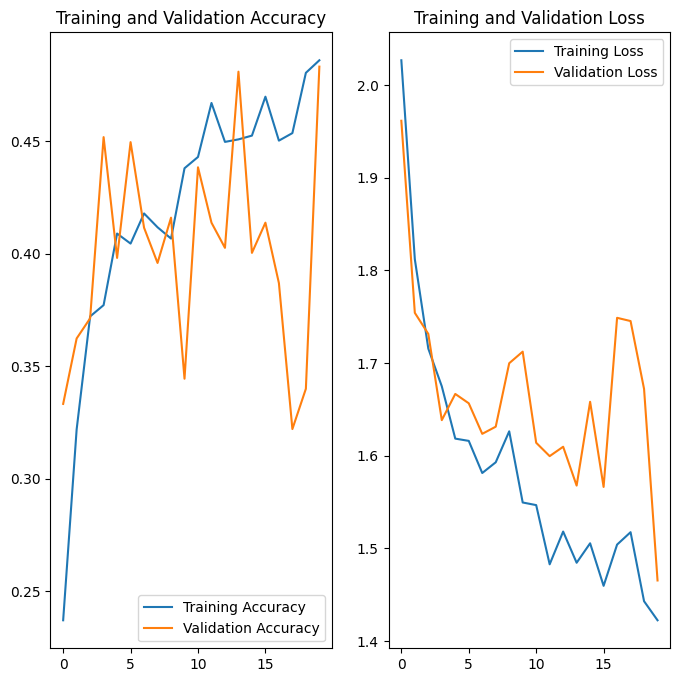

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Performance on test dataset

In [31]:
test_eval_result = model.evaluate(test_ds)
dict(zip(model.metrics_names, test_eval_result))

4/4 [==============================] - 1s 18ms/step - loss: 2.0645 - accuracy: 0.2881


{'loss': 2.0645220279693604, 'accuracy': 0.2881355881690979}

#### Model Performance Summary

The image transformation augmentation did not help and the performance is pretty much similar (although a little worse). We need to increase the number of input samples in the next exercise using Augmentor library to see whether it improves the model.

## Data Augmentation using Augmentor

In order to generate the additional images, we are going to use  `Augmentor` (https://augmentor.readthedocs.io/en/master/) library for Train dataset

### Installation

In [32]:
!pip install Augmentor

Defaulting to user installation because normal site-packages is not writeable


### Using Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


#### Samples Generation

We will address the imbalance among the classes by generating needed images as well as add additional 500 images to each class. So for example, **seborrheic keratosis** will get (462-77)+500 new images, which is 885 and that will make total images for each class 962 images.

We have stored the count of missing images in ```samples_to_augment``` dictionary.

In [33]:
path_to_training_dataset=str(data_dir_train) +"/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(samples_to_augment[i]+500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F7AA1196920>: 100%|██████████| 848/848 [00:01<00:00, 577.57 Samples/s] 


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F79ECBCBFD0>: 100%|██████████| 586/586 [00:01<00:00, 552.89 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F78E05EBB80>: 100%|██████████| 867/867 [00:01<00:00, 550.88 Samples/s]                   


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F7AA12AB1F0>: 100%|██████████| 524/524 [00:03<00:00, 152.70 Samples/s] 


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F788F89EC20>: 100%|██████████| 605/605 [00:04<00:00, 138.48 Samples/s]                    


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7AA11658A0>: 100%|██████████| 500/500 [00:00<00:00, 596.01 Samples/s]                  


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F788F7DD1B0>: 100%|██████████| 885/885 [00:02<00:00, 297.33 Samples/s] 


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F788F906B90>: 100%|██████████| 781/781 [00:01<00:00, 659.30 Samples/s]                   


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F78C02507F0>: 100%|██████████| 823/823 [00:01<00:00, 675.53 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

#### Samples Generation Summary

Augmentor generated total 6419 new images in the output subdirectories of class directories.

In [34]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
len(path_list_new)

6419

In [39]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [40]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [41]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [42]:
new_df=pd.concat([original_df,df2])

In [43]:
new_df['Label'].value_counts()

Label
actinic keratosis             962
vascular lesion               962
seborrheic keratosis          962
nevus                         962
melanoma                      962
basal cell carcinoma          962
squamous cell carcinoma       962
dermatofibroma                962
pigmented benign keratosis    962
Name: count, dtype: int64

So, now we have added equal amount of images to all the classes to maintain some class balance. Now total **8658** images are available for training compared to 2357 original images.

# Building CNN on Augmented Data

We will build the model using the increased no. of images and see whether it performs better than earlier.

In [46]:
batch_size = 32
img_height = 128
img_width = 128

## Setting up Datasets

Since the no. of images is increased, we can take train-validation split as 70:30 as it was observed that with 80:20 split models were getting consistently overfit (validation performance was poor)

In [48]:
(train_images_set,val_images_set)=tf.keras.utils.image_dataset_from_directory(data_dir_train,seed=120,image_size=(128,128),validation_split=0.3,subset="both")
train_ds = train_images_set
val_ds = val_images_set

AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 8658 files belonging to 9 classes.
Using 6061 files for training.
Using 2597 files for validation.


## CNN Model - 5

We will use simple filters and 128 neuron FC layer (similar to CNN Model - 1) but with more images.

In [49]:
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  layers.Conv2D(16, 3, padding='same', activation='relu'),

  layers.Dropout(0.2),

  layers.MaxPooling2D(),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.Dropout(0.2),
    
  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  
  layers.Dropout(0.2),

  layers.MaxPooling2D(),

  layers.Flatten(),


  layers.Dense(128, activation='relu'),

  layers.Dropout(0.2),
  
  layers.Dense(num_classes)
  
])



### Compile the model

In [50]:
## Your code goes here
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 128, 128, 16)      448       
                                                                 
 dropout_15 (Dropout)        (None, 128, 128, 16)      0         
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 64, 64, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 64, 64, 32)        4640      
                                                                 
 dropout_16 (Dropout)        (None, 64, 64, 32)        0         
                                                      

### Training the model

In [51]:
epochs = 20
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
190/190 [==============================] - 9s 31ms/step - loss: 1.7658 - accuracy: 0.3148 - val_loss: 1.5385 - val_accuracy: 0.4301
Epoch 2/20
190/190 [==============================] - 6s 31ms/step - loss: 1.4101 - accuracy: 0.4582 - val_loss: 1.4242 - val_accuracy: 0.4386
Epoch 3/20
190/190 [==============================] - 6s 33ms/step - loss: 1.2252 - accuracy: 0.5469 - val_loss: 1.3279 - val_accuracy: 0.5079
Epoch 4/20
190/190 [==============================] - 8s 41ms/step - loss: 1.1041 - accuracy: 0.5973 - val_loss: 1.1967 - val_accuracy: 0.5830
Epoch 5/20
190/190 [==============================] - 8s 40ms/step - loss: 0.9054 - accuracy: 0.6641 - val_loss: 1.0961 - val_accuracy: 0.6350
Epoch 6/20
190/190 [==============================] - 8s 40ms/step - loss: 0.7907 - accuracy: 0.7076 - val_loss: 0.8929 - val_accuracy: 0.6785
Epoch 7/20
190/190 [==============================] - 8s 40ms/step - loss: 0.6343 - accuracy: 0.7667 - val_loss: 0.7738 - val_accuracy: 0.7428

### Visualizing training results

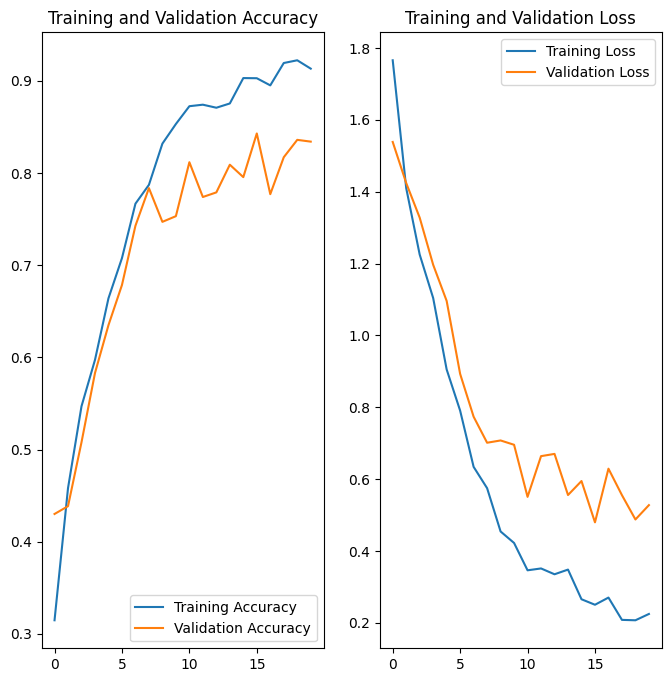

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Performance on test data

In [53]:
test_eval_result = model.evaluate(test_ds)
dict(zip(model.metrics_names, test_eval_result))

4/4 [==============================] - 1s 5ms/step - loss: 3.7188 - accuracy: 0.3983


{'loss': 3.718813896179199, 'accuracy': 0.39830508828163147}

### Model Performance Summary

As far as training and validation sets are concerned this model is neither overfitting nor underfitting. However, the performance on test data is better than the previous models but it's around 0.4.

This suggests that the model is still overfit on train data and performs not so good on unseen data.

## CNN Model - 6

This model has doubled parameters with respect to filters and has two dense layers of 256 neurons each in FC Layer.

The goal of this model is to be better than Model - 5

### Compilation and Training

In [54]:

num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  
  layers.Conv2D(32, 3, padding='same', activation='relu'),

  layers.Dropout(0.2),

  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Dropout(0.2),
    
  layers.MaxPooling2D(),

  layers.Conv2D(128, 3, padding='same', activation='relu'),
  
  layers.Dropout(0.2),

  layers.MaxPooling2D(),

  layers.Flatten(),

  layers.Dense(256, activation='relu'),

  layers.Dropout(0.2),

  layers.Dense(256, activation='relu'),

  layers.Dropout(0.2),

  layers.Dense(num_classes)
])

## Your code goes here
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

epochs = 20
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_17 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 dropout_19 (Dropout)        (None, 128, 128, 32)      0         
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 64, 64, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_18 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 dropout_20 (Dropout)        (None, 64, 64, 64)        0         
                                                      

### Visualizing training results

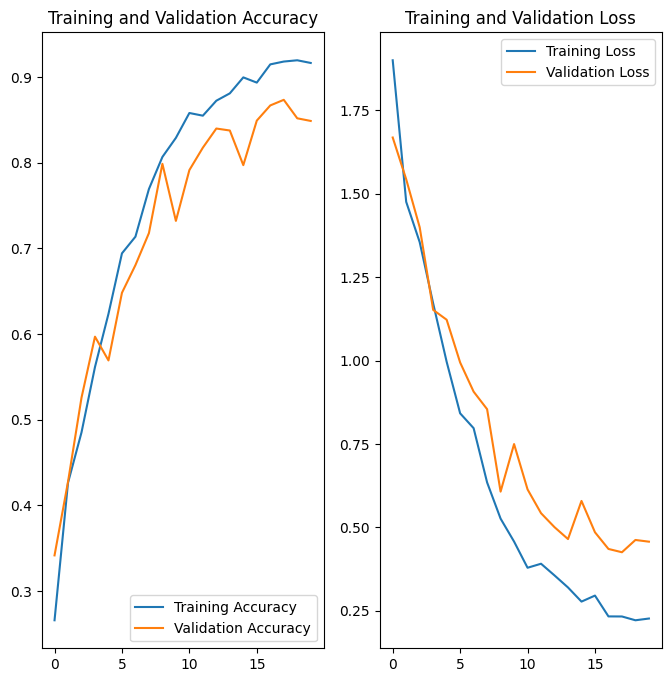

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Performance on Test Data

In [56]:

test_eval_result = model.evaluate(test_ds)
dict(zip(model.metrics_names, test_eval_result))

4/4 [==============================] - 1s 19ms/step - loss: 3.2568 - accuracy: 0.3898


{'loss': 3.2568185329437256, 'accuracy': 0.38983049988746643}

### Model Performance Summary

Not much difference than Model - 5 so looks like the no. of increased filters and neurons are not much helping atleast for the unseen data.

## CNN Model - 7

In this model we are increasing the no. of filter layers compared to Model - 6 to see whether that increases the performance on unseen data.

### Compilation and Training

In [57]:

num_classes = 9


model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  layers.Conv2D(32, 3, padding='same', activation='relu'),

  layers.Dropout(0.2),

  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Dropout(0.2),
    
  layers.MaxPooling2D(),

  layers.Conv2D(128, 3, padding='same', activation='relu'),
  
  layers.Dropout(0.2),

  layers.MaxPooling2D(),

  layers.Conv2D(128, 3, padding='same', activation='relu'),
  
  layers.Dropout(0.2),
  
  layers.MaxPooling2D(),

  layers.Flatten(),

  layers.Dense(256, activation='relu'),

  layers.Dropout(0.2),

  layers.Dense(256, activation='relu'),

  layers.Dropout(0.2),  
  
  layers.Dense(num_classes)
  
])


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

epochs = 20

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 dropout_24 (Dropout)        (None, 128, 128, 32)      0         
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 64, 64, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 dropout_25 (Dropout)        (None, 64, 64, 64)        0         
                                                      

### Visualizing Training Summary

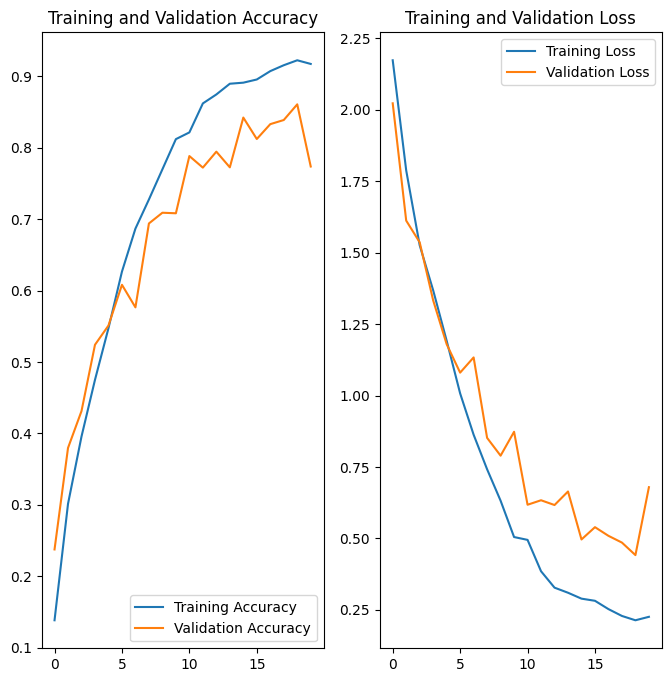

In [58]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Performance on test dataset

In [59]:

test_eval_result = model.evaluate(test_ds)
dict(zip(model.metrics_names, test_eval_result))

4/4 [==============================] - 1s 20ms/step - loss: 2.9266 - accuracy: 0.4831


{'loss': 2.926582098007202, 'accuracy': 0.4830508530139923}

### Model Performance Summary

This model certainly is an improvement on the previous ones. There is not much overfitting with respect to train and validation sets.

The performance of this model on unseen (test) data is also decent compared to previous ones, although not at par one would expect to have with CNN model.

# Summary

The abundance of training data is an absolute need to build efficient CNN models. When we built the models with un-augmented data, the performance of the models was not up to the par and as a matter of fact most of them underfit.

The transformation augmentation could be a good technique to introduce variety in the train dataset however given our small amount of dataset, did not help much.

However after generating new images using Augmentor library, and providing all of them as training dataset the performance improved (model 5, 6, and 7) not just on training and validation dataset but also on test dataset.